### Training a simple convolutional neural network on the cifar-10 dataset

#### Import packages
Here we are using [Keras](https://github.com/keras-team/keras) with [TensorFlow](https://www.tensorflow.org/) to develop a **convolutional neural network (CNN)** to training the classification of objects in the [cifar-10 dataset](http://www.cs.utoronto.ca/~kriz/cifar.html).

In [ ]:
! nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-14f085e3-2209-499f-10a9-676ea235ba77)


In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

from keras.datasets import cifar10

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('ggplot')

print("Num Of GPU Available", len(tf.config.list_physical_devices('GPU')))


Num Of GPU Available 1


Explicitly define our cifar-10 image dimensions which will be used later to reshape our data.

#### Load data
We load our cifar-10 data.

In [ ]:
img_rows, img_cols = 32, 32

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 3)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 3)

print ("x_train: ", x_train.shape)
print ("y_train: ", y_train.shape)
print ("x_test: ", x_test.shape)
print ("x_test: ", y_test.shape)

170500096/170498071 [==============================] - 4s 0us/step
x_train:  (50000, 32, 32, 3)
y_train:  (50000, 1)
x_test:  (10000, 32, 32, 3)
x_test:  (10000, 1)


#### Data preprocessing 

We also normalize the pixel values and convert class vectors to binary class matrices like we did previously.

In [ ]:
input_shape = (img_rows, img_cols, 3)

num_classes = 10
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# normalization
x_train /= 255
x_test /= 255

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [ ]:
filter_size     = (3,3)
optimizer_name  = 'Adam'
activation_func = 'elu'
batch_size      = 128
epochs          = 80

model = tf.keras.Sequential()

model.add(Conv2D(256, kernel_size=filter_size, 
          strides=(1,1),
          padding='same', # adds sufficient padding to the input so that the output has same dimension as input
          input_shape=input_shape,
          use_bias=True, 
          kernel_initializer='glorot_uniform',
          bias_initializer='zeros',
          activation=activation_func))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv2D(256, kernel_size=filter_size, padding='same', activation=activation_func))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Conv2D(256, kernel_size=filter_size, padding='same', activation=activation_func))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Conv2D(128, kernel_size=filter_size, padding='same', activation=activation_func))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Conv2D(128, kernel_size=filter_size, padding='same', activation=activation_func))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(64, kernel_size=filter_size, padding='same', activation=activation_func))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(64, kernel_size=filter_size, padding='same', activation=activation_func))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(tf.keras.layers.Flatten())
model.add(Dropout(0.5))
model.add(Dense(128, activation=activation_func))
model.add(BatchNormalization())
model.add(Dropout(0.8))

# Classifier
model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 256)       7168      
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 256)       1024      
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 256)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 256)       590080    
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 256)       1024      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 256)       5

In [ ]:
model.compile(optimizer=optimizer_name,              
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
def lr_schedule(epoch):
    lrate = 0.001
    if epoch > 35:
        lrate = 0.0005
    elif epoch > 70:
        lrate = 0.00025      
    return lrate

In [ ]:
#data augmentation
datagen = ImageDataGenerator(
    rotation_range=12,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.3,
    )
datagen.fit(x_train)

## Training our model


Here we instantiate the values of hyperparameters that we will be using later. 

In [ ]:
'''
model_log = model.fit(x_train, y_train,
                      batch_size=batch_size, # number of samples to be used for each gradient update
                      epochs=epochs, # number of iterations over the entire x_train data#                      
                      validation_split = 0.1, #validation_data=(x_test, y_test), # on which to evaluate loss and model metrics at the end of each epoch
                     )
'''


model_log = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size), steps_per_epoch=x_train.shape[0] // batch_size, 
                      epochs=epochs, verbose=1, validation_data=(x_test,y_test), callbacks=[LearningRateScheduler(lr_schedule)])



Epoch 1/80
390/390 [==============================] - 64s 84ms/step - loss: 3.2986 - accuracy: 0.2008 - val_loss: 2.9759 - val_accuracy: 0.1603
Epoch 2/80
390/390 [==============================] - 32s 81ms/step - loss: 1.7631 - accuracy: 0.3525 - val_loss: 1.7288 - val_accuracy: 0.3921
Epoch 3/80
390/390 [==============================] - 32s 82ms/step - loss: 1.5044 - accuracy: 0.4537 - val_loss: 1.9702 - val_accuracy: 0.4222
Epoch 4/80
390/390 [==============================] - 32s 82ms/step - loss: 1.3446 - accuracy: 0.5139 - val_loss: 1.1957 - val_accuracy: 0.5893
Epoch 5/80
390/390 [==============================] - 32s 82ms/step - loss: 1.2066 - accuracy: 0.5744 - val_loss: 1.1723 - val_accuracy: 0.5776
Epoch 6/80
390/390 [==============================] - 32s 82ms/step - loss: 1.1058 - accuracy: 0.6186 - val_loss: 0.8654 - val_accuracy: 0.6884
Epoch 7/80
390/390 [==============================] - 32s 82ms/step - loss: 1.0162 - accuracy: 0.6482 - val_loss: 0.8826 - val_accuracy:

## Plotting out the accuracy and loss
Below we plot out the trend of the accuracy and loss of both the training set and validation set.

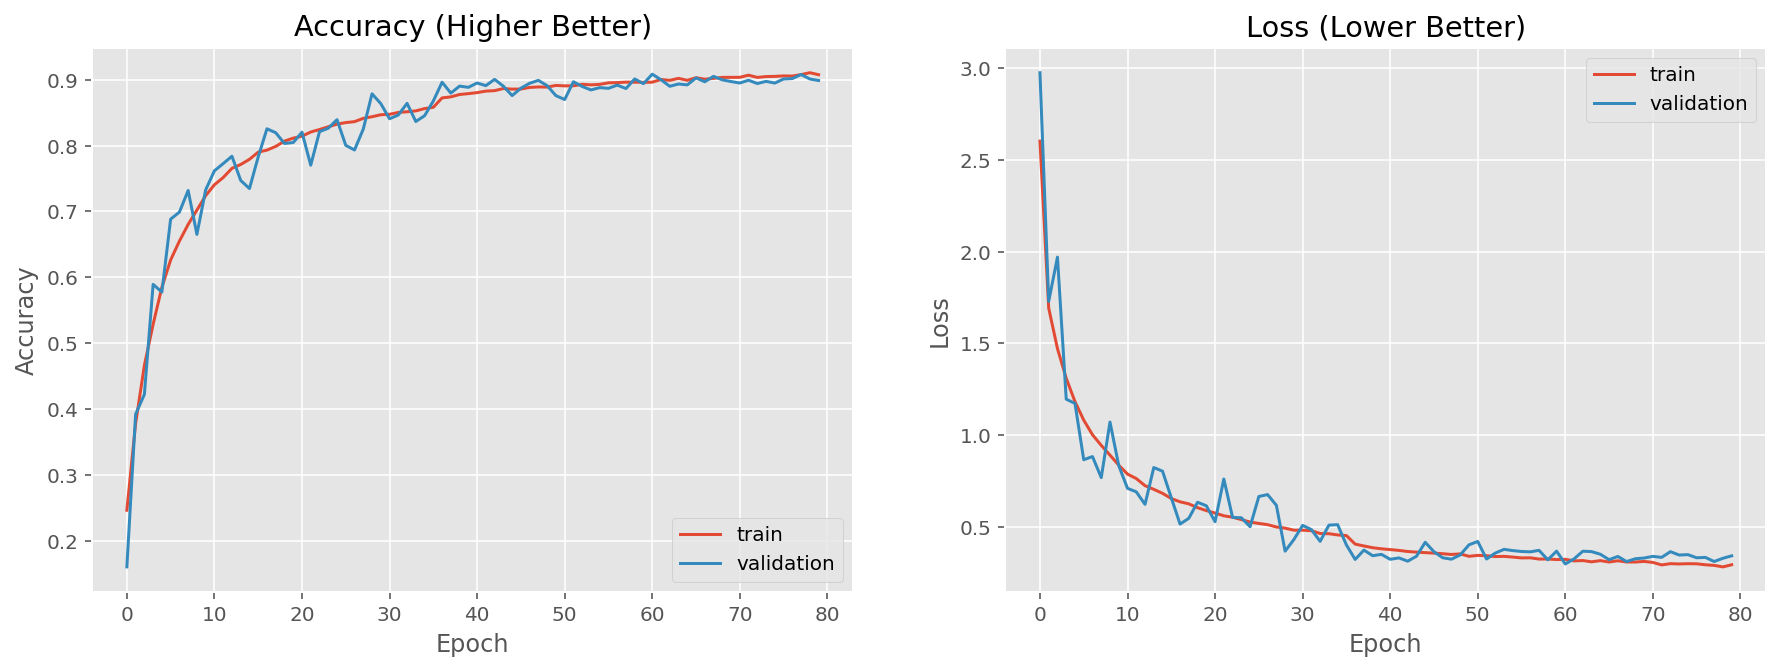

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))

ax1.plot(model_log.history['accuracy'])
ax1.plot(model_log.history['val_accuracy'])
ax1.set_title('Accuracy (Higher Better)')
ax1.set(xlabel='Epoch', ylabel='Accuracy')
ax1.legend(['train', 'validation'], loc='lower right')
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

ax2.plot(model_log.history['loss'])
ax2.plot(model_log.history['val_loss'])
ax2.set_title('Loss (Lower Better)')
ax2.set(xlabel='Epoch', ylabel='Loss')
ax2.legend(['train', 'validation'], loc='upper right')
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))

In [ ]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.3413228392601013
Test accuracy: 0.8988999724388123


In [ ]:
saved_model_dir = 'saved_model'
tf.saved_model.save(model, saved_model_dir)
 
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()
 
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: saved_model/assets


#### Visualizing the wrongly classified data

In [ ]:
output = model.predict_classes(x_test)
print (output)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[3 8 8 ... 5 1 7]


In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
y_train = y_train.reshape(y_train.shape[0])
y_test = y_test.reshape(y_test.shape[0])

ind = np.where(np.equal(output, y_test)==0)

In [ ]:
err_x = x_test[ind[0]]
err_y = output[ind[0]]
print (err_x.shape)

(1011, 32, 32, 3)


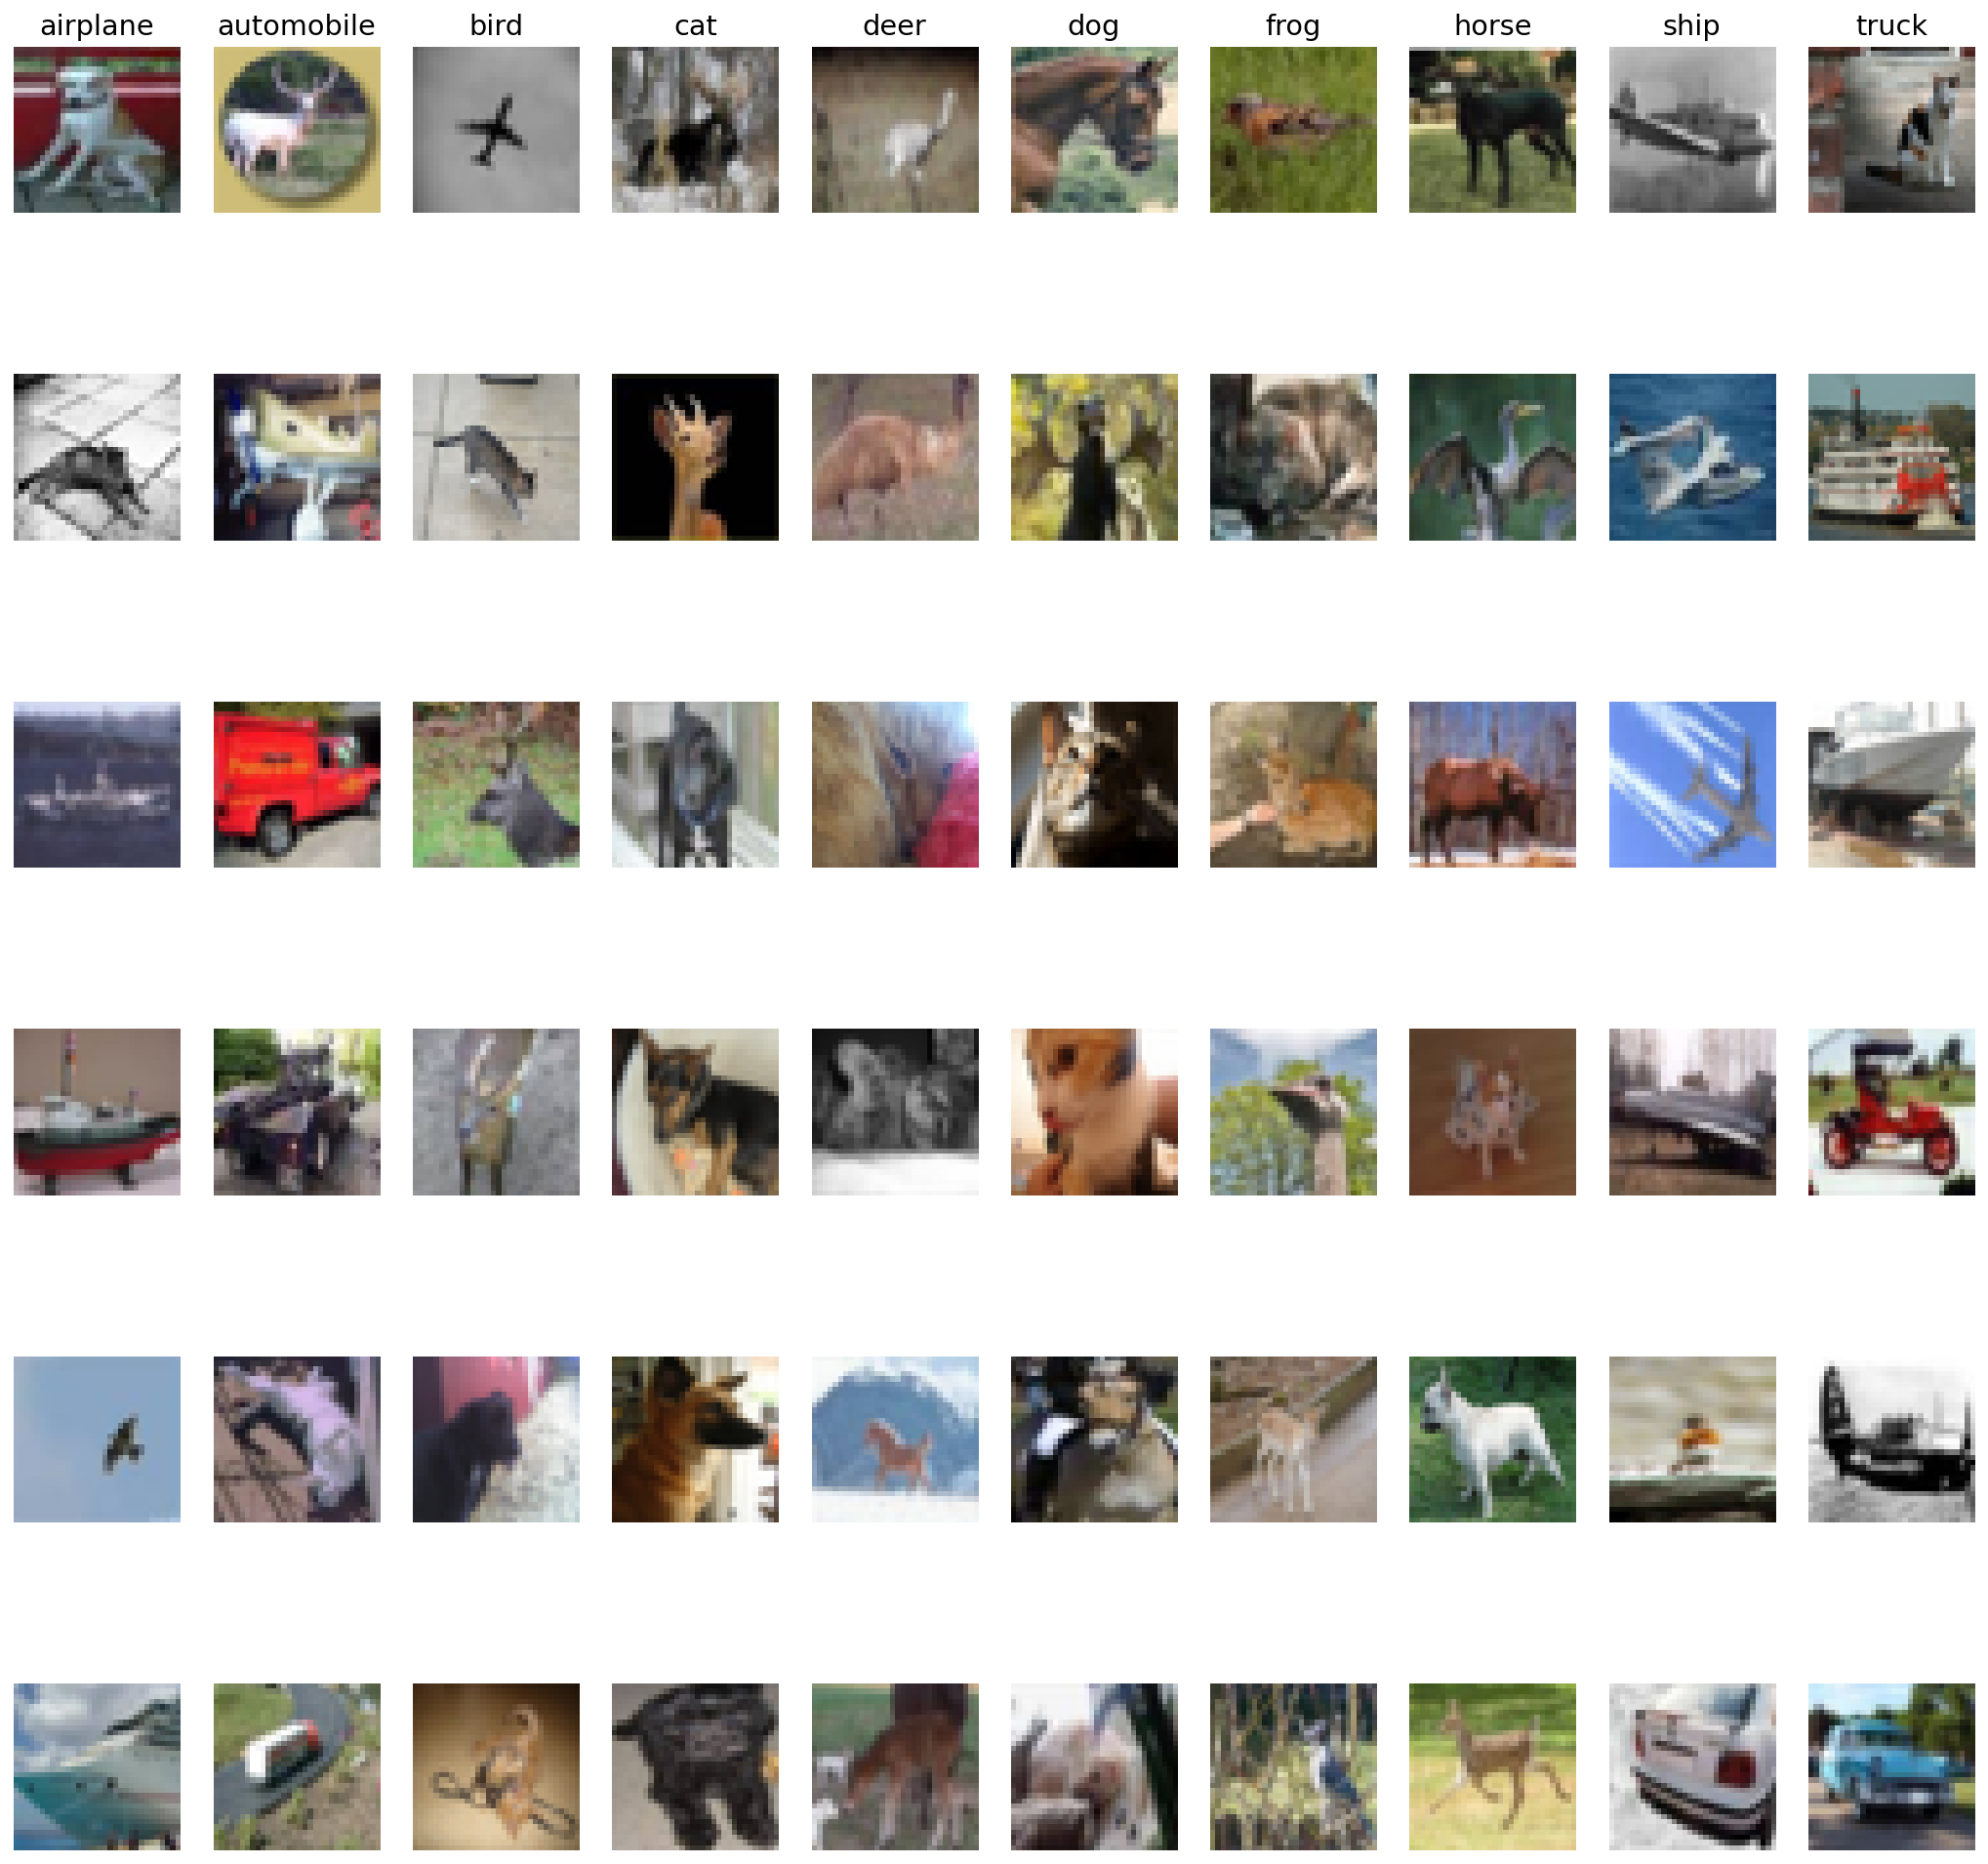

In [ ]:
examples_per_class = 6
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(18,18))
for cls, cls_name in enumerate(classes):
  idxs = np.where(cls == err_y)
  idxs = np.random.choice(idxs[0], examples_per_class, replace=False)
  for i, idx in enumerate(idxs):
    plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
    plt.imshow(err_x[idx].astype('uint8'), cmap = 'gray')
    plt.axis('off')
    if i == 0:
      plt.title(cls_name)
plt.show()